<br>
<br>

# 🤖 Ensemble Learning — Menggabungkan Model untuk Kinerja Lebih Baik

Pada bagian ini, kita akan mempelajari bagaimana **menggabungkan beberapa model machine learning** (disebut *base learners*) menjadi satu model yang lebih kuat — pendekatan ini dikenal sebagai **Ensemble Learning**.

Tujuan utama ensemble adalah **meningkatkan akurasi, stabilitas, dan generalisasi** dengan cara memanfaatkan kelebihan masing-masing model.

---

## 📘 **Alur Eksperimen Lengkap**

1) **Persiapan Lingkungan & Data**
   - Menggunakan *dataset Iris* (bawaan `sklearn.datasets`) dan *Wine* (UCI Repository).
   - Melakukan *preprocessing* seperti encoding label, scaling, dan split data latih/uji.

2) **Eksperimen Ensemble Models:**
   - **Majority Voting (Hard Voting Classifier)**  
     Menggabungkan beberapa model (Logistic Regression, Decision Tree, KNN)  
     → Prediksi akhir diambil berdasarkan *mayoritas suara kelas*.
   - **Bagging (Bootstrap Aggregating)**  
     Melatih banyak model independen dari sampel acak data latih  
     → Mengurangi *variance* dan meningkatkan stabilitas model (contoh: Decision Tree + Bagging).
   - **AdaBoost (Adaptive Boosting)**  
     Melatih model secara bertahap, memberi bobot lebih besar pada data yang salah diklasifikasikan  
     → Mengurangi *bias* model sederhana dengan memperbaiki kesalahan secara iteratif.
   - **XGBoost (Extreme Gradient Boosting)**  
     Versi modern dari boosting berbasis *gradient descent*  
     → Lebih cepat, lebih stabil, dan memiliki regularisasi bawaan untuk mencegah overfitting.

3) **Evaluasi & Analisis**
   - Menggunakan metrik evaluasi:
     - **ROC AUC** untuk membandingkan performa antar model,
   - Visualisasi hasil:
     - Plot *ROC curve* tiap model,
     - *Decision boundary* visual untuk tiap metode voting,
     - Perbandingan performa ensemble vs model tunggal.

---

## 🧠 **Tujuan Pembelajaran**

Melalui eksperimen ini, mahasiswa diharapkan dapat:
- Memahami konsep **ensemble learning** dan alasan mengapa model gabungan sering lebih unggul daripada model tunggal.
- Mampu membangun dan mengevaluasi model:
  - **Majority Voting Classifier** (gabungan sederhana),
  - **BaggingClassifier** (bootstrap ensemble),
  - **AdaBoostClassifier** (adaptive boosting),
  - **XGBoostClassifier** (gradient boosting ekstrem).
- Membandingkan performa tiap metode dalam hal akurasi dan stabilitas.

---

## ⚙️ **Model yang Akan Digunakan**
| Model | Jenis Ensemble | Tujuan Utama | Ciri Khas |
|--------|----------------|---------------|-------------|
| **Majority Voting** | Simple averaging | Menggabungkan model berbeda (heterogen) | Prediksi diambil dari mayoritas suara |
| **Bagging** | Parallel ensemble | Mengurangi variansi | Tiap model dilatih dari data bootstrap |
| **AdaBoost** | Sequential ensemble | Mengurangi bias | Tiap model belajar dari kesalahan sebelumnya |
| **XGBoost** | Gradient-based boosting | Performa tinggi & regularisasi | Optimasi loss dengan gradien & shrinkage |

---

## 🎯 **Tujuan Akhir**
Notebook ini menjadi latihan komprehensif untuk:
- Menunjukkan **evolusi teknik ensemble** — dari voting sederhana hingga boosting modern,
- Menggambarkan bagaimana pendekatan *“bekerja bersama lebih baik daripada sendiri”* meningkatkan performa,
- Menghasilkan model prediksi yang **lebih akurat dan lebih tahan terhadap overfitting**.

> ✨ Dengan memahami alur ini, kamu akan menguasai konsep dasar ensemble — landasan dari banyak model *state-of-the-art* di kompetisi seperti **Kaggle** dan aplikasi nyata seperti diagnosis medis, keuangan, dan deteksi anomali.

---


## 🧩 MajorityVoteClassifier — Klasifier Ensemble dengan Voting Mayoritas

Kelas `MajorityVoteClassifier` merupakan implementasi manual dari **ensemble voting classifier**,  
yang menggabungkan beberapa model berbeda untuk menghasilkan satu prediksi akhir.

### ⚙️ Konsep Utama
- Setiap *classifier* dilatih secara terpisah menggunakan data yang sama.  
- Prediksi akhir diambil berdasarkan:
  - **Class label voting** → memilih kelas dengan suara terbanyak (default).  
  - **Probability voting** → memilih kelas dengan rata-rata probabilitas tertinggi.

### 🧠 Komponen Utama
- `__init__` → menerima daftar classifier, tipe voting (`classlabel` atau `probability`), dan bobot (opsional).  
- `fit()` → melatih semua model dan melakukan *encoding* label agar seragam.  
- `predict()` → menggabungkan hasil prediksi model-model dasar dan menentukan hasil akhir berdasarkan suara terbanyak.  
- `predict_proba()` → menghitung rata-rata probabilitas kelas dari semua model.  
- `get_params()` → memungkinkan tuning hyperparameter melalui `GridSearchCV`.

### 🎯 Tujuan
Mendemonstrasikan cara kerja **voting ensemble** dari awal tanpa library bawaan sklearn,  
serta memberikan fleksibilitas untuk eksplorasi model heterogen seperti Logistic Regression, Decision Tree, dan KNN.


In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np
import sklearn

# Tujuan utama: meta-estimator yang menggabungkan beberapa classifier
    # via voting (class label) atau averaging (probability).
    # - classifiers: list model dasar (mis. LR, DT, KNN)
    # - vote: 'classlabel' (voting mayoritas label) atau 'probability' (rata-rata proba)
    # - weights: bobot untuk masing-masing classifier (opsional)
base_classes = (ClassifierMixin, BaseEstimator) if sklearn.__version__ >= "0.16" else (BaseEstimator, ClassifierMixin)

class MajorityVoteClassifier(*base_classes):

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        # _name_estimators memberi nama unik tiap estimator (perlu untuk get_params dan grid search)
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
         # Validasi opsi voting
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'; got (vote={self.vote})")
        # Validasi panjang weights (jika ada)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal; got {len(self.weights)} weights, {len(self.classifiers)} classifiers')
        # LabelEncoder: memastikan label jadi 0..K-1
        # Alasan penting: np.bincount di bawah butuh label integer non-negatif berurutan.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        # Melatih salinan (clone) setiap classifier:
        # - clone() menjaga agar instance asli tidak termodifikasi
        # - aman untuk dipakai berulang dalam pipeline/GSCV
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
         # Dua mode prediksi:
        # 1) 'probability': pilih kelas dengan rata-rata probabilitas tertinggi
        #    (butuh semua base classifier dukung predict_proba).
        # 2) 'classlabel': voting mayoritas atas label prediksi masing-masing classifier.
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # Kumpulkan prediksi label dari tiap classifier (bentuk: [n_samples, n_classifiers])
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            # Voting mayoritas per sampel.
            # np.bincount menghitung frekuensi tiap label; 'weights' menerapkan bobot (weighted voting).
            # np.argmax memilih label dengan frekuensi (atau bobot) terbesar.
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


## Menggunakan Prinsip Voting Mayoritas untuk Membuat Prediksi

In [2]:
# Import library yang dibutuhkan
from sklearn import datasets
import numpy as np                                   # Silakan diisi bagian ini dengan kode yang tepat (1)
import pandas as pd                                   # Silakan diisi bagian ini dengan kode yang tepat (1)
from sklearn.preprocessing import LabelEncoder

# Muat dataset Iris bawaan scikit-learn
iris = datasets.load_iris()                             # Silakan diisi bagian ini dengan kode yang tepat (2)

# Ambil hanya 2 fitur (kolom ke-1 = sepal width, kolom ke-2 = petal length)
# dan gunakan hanya 100 data terakhir (2 kelas: Versicolor & Virginica)
X = iris.data[50:, [1, 2]]
y = iris.target[50:]                                

# Encode label kelas agar menjadi 0 dan 1
# 1 -> 0 (Versicolor), 2 -> 1 (Virginica)
le = LabelEncoder()                                        # Silakan diisi bagian ini dengan kode yang tepat (2) 
y = le.fit_transform(y)

# Buat DataFrame untuk melihat isi data
df_iris = pd.DataFrame(X, columns=['sepal width (cm)', 'petal length (cm)'])
df_iris['target'] = y

# Tampilkan 5 baris pertama data
print("Kelas unik:", np.unique(y))

df_iris.head()                                     # Silakan diisi bagian ini dengan kode yang tepat (1)


Kelas unik: [0 1]


,sepal width (cm),petal length (cm),target
0,3.2,4.7,0
1,3.2,4.5,0
2,3.1,4.9,0
3,2.3,4.0,0
4,2.8,4.6,0


In [3]:
from sklearn.model_selection import train_test_split                          # Silakan diisi bagian ini dengan kode yang tepat (2)

# Bagi dataset menjadi data latih (train) dan data uji (test)
X_train, X_test, y_train, y_test = train_test_split(                                      # Silakan diisi bagian ini dengan kode yang tepat (1)
    X, y,                                                     # Silakan diisi bagian ini dengan kode yang tepat (1)
    test_size= 0.5,            # 50% data untuk pengujian                # Silakan diisi bagian ini dengan kode yang tepat (1)
    random_state= 1,              # agar hasil pembagian konsisten          # Silakan diisi bagian ini dengan kode yang tepat (1)
    stratify=y            # jaga proporsi kelas tetap seimbang      # Silakan diisi bagian ini dengan kode yang tepat (2)
)

print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test :", X_test.shape)                                # Silakan diisi bagian ini dengan kode yang tepat (1)

# Periksa distribusi kelas untuk memastikan seimbang
print("\nDistribusi label:")
print("Total :", np.bincount(y))
print("Train :", np.bincount(y_train))
print("Test  :", np.bincount(y_test))


Ukuran X_train: (50, 2)
Ukuran X_test : (50, 2)

Distribusi label:
Total : [50 50]
Train : [25 25]
Test  : [25 25]


## 🧠 Membandingkan Model Dasar Menggunakan 10-Fold Cross Validation

Sebelum membangun model **ensemble (voting)**, langkah ini bertujuan untuk **mengevaluasi performa model dasar secara individual**.

---

### ⚙️ **Model yang Digunakan**

Kita akan menggunakan tiga model dasar dengan parameter sederhana untuk melihat karakteristiknya masing-masing sebelum digabungkan ke dalam *ensemble model*:

1. **Logistic Regression (LR)**  
   - `C` kecil (misal **0.001**) → regularisasi kuat → membantu mencegah *overfitting*.  
   - Model linear yang cocok untuk klasifikasi biner sederhana.  
   - Perlu **standarisasi fitur** sebelum dilatih karena sensitif terhadap skala data.

2. **Decision Tree (DT)**  
   - `max_depth=1` menghasilkan **decision stump** — pohon sangat dangkal yang hanya membuat satu pembagian utama.  
   - Digunakan untuk ilustrasi *weak learner*, yaitu model sederhana yang sering jadi dasar *ensemble methods* seperti Bagging atau Boosting.  
   - Tidak memerlukan scaling fitur karena berbasis pemisahan nilai, bukan jarak.

3. **K-Nearest Neighbors (KNN)**  
   - `n_neighbors=1` (K kecil) membuat model sangat “tajam” atau sensitif terhadap data latih.  
   - Berguna untuk menunjukkan efek *scaling* dan *voting* karena KNN menghitung jarak antar data.  
   - Perlu **StandardScaler** untuk memastikan perhitungan jarak tidak bias karena skala fitur yang berbeda.

---

### 🧩 **Pipeline**

Dua model (Logistic Regression & KNN) dimasukkan ke dalam **Pipeline** yang berisi `StandardScaler()` agar fitur distandarisasi sebelum pelatihan.  
Decision Tree tidak perlu pipeline karena tidak terpengaruh oleh skala fitur.

---

### 🧪 **Evaluasi**

Evaluasi dilakukan dengan **10-Fold Cross Validation (cv=10)** untuk memastikan hasil tidak bergantung pada satu pembagian data saja.  
Metrik yang digunakan adalah **ROC AUC (Area Under the Curve)** yang mengukur kemampuan model membedakan dua kelas.

---

### 📊 **Output**

Hasil program akan menampilkan nilai rata-rata dan standar deviasi ROC AUC dari masing-masing model,  
sehingga dapat dibandingkan performa antar algoritma.

---

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,                # Silakan diisi bagian ini dengan kode yang tepat (1)
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth= 1,           # Silakan diisi bagian ini dengan kode yang tepat (1)
                              criterion='entropy',
                              random_state=1)

clf3 = KNeighborsClassifier(n_neighbors = 1,            # Silakan diisi bagian ini dengan kode yang tepat (1)
                            p=2,
                            metric='minkowski')

# Pipeline untuk memastikan fitur diskalakan sebelum model dilatih
pipe1 = Pipeline([['sc', StandardScaler()],  # scaling untuk Logistic Regression
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],            # Silakan diisi bagian ini dengan kode yang tepat (2)
                  ['clf', clf3]])            # Silakan diisi bagian ini dengan kode yang tepat (1)

# Label untuk identifikasi model saat evaluasi
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

# Evaluasi masing-masing model menggunakan 10-fold CV dan metrik ROC AUC
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):                         # Silakan diisi bagian ini dengan kode yang tepat (2)
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,            # 10 fold untuk validasi silang
                             scoring='roc_auc')  # metrik evaluasi ROC AUC
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


## 🗳️ Majority Rule (Hard Voting)

Pada tahap ini, tiga model dasar (Logistic Regression, Decision Tree, dan KNN)  
digabungkan menggunakan **metode Majority Voting (Hard Voting)**,  
di mana **kelas dengan suara terbanyak** dari ketiga model akan menjadi hasil prediksi akhir.

Langkah ini membandingkan performa ensemble (*mv_clf*)  
dengan performa masing-masing model tunggal menggunakan metrik **ROC AUC**  
melalui **10-fold cross validation**.


In [5]:
# Membuat model ensemble menggunakan voting mayoritas (hard voting)
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])                   # Silakan diisi bagian ini dengan kode yang tepat (2)

# Menambahkan label 'Majority voting' untuk keperluan tampilan hasil
clf_labels += ['Majority voting']

# Gabungkan semua model (individual + ensemble) ke dalam satu list
all_clf = [pipe1, clf2, pipe3, mv_clf]                                              # Silakan diisi bagian ini dengan kode yang tepat (2)

# Evaluasi semua model menggunakan 10-fold CV dengan metrik ROC AUC
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,             # gunakan 10 fold cross-validation
                             scoring='roc_auc') # metrik evaluasi: ROC AUC
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## 📊 Visualisasi ROC Curve untuk Setiap Model

Bagian ini memvisualisasikan **kurva ROC (Receiver Operating Characteristic)**  
untuk membandingkan performa semua model (Logistic Regression, Decision Tree, KNN, dan Majority Voting).  

ROC Curve menunjukkan hubungan antara:
- **True Positive Rate (TPR)** dan  
- **False Positive Rate (FPR)**  

Semakin luas area di bawah kurva (**AUC**), semakin baik kemampuan model membedakan kelas positif dan negatif.


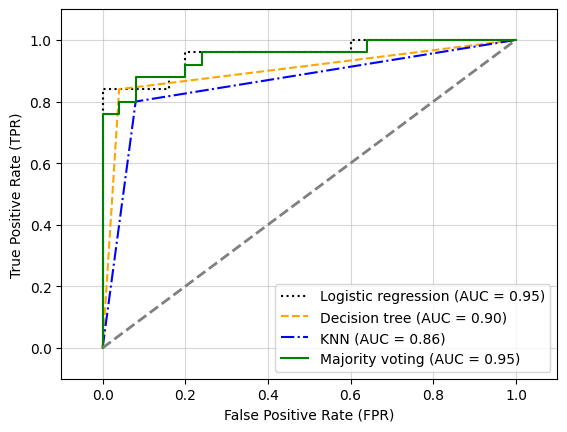

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Warna & gaya garis untuk tiap model
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

# Loop untuk setiap model (termasuk ensemble)
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    # Prediksi probabilitas kelas positif (kelas = 1)
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

    # Hitung nilai False Positive Rate (FPR) dan True Positive Rate (TPR)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)

    # Hitung area di bawah kurva (AUC)
    roc_auc = auc(x=fpr, y=tpr)

    # Gambar ROC curve untuk model saat ini
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (AUC = {roc_auc:.2f})')

# Tambahkan legenda & garis diagonal acuan (model acak)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

# Format tampilan plot
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()


## ⚖️ Standarisasi Fitur (Feature Scaling)

Langkah ini menstandarisasi fitur menggunakan **`StandardScaler`**,  
yang mengubah setiap fitur agar memiliki **mean = 0** dan **standar deviasi = 1**.  

Proses ini penting terutama untuk model berbasis jarak (seperti KNN) atau regresi,  
agar setiap fitur memiliki kontribusi yang seimbang dalam proses pembelajaran.


In [7]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

## 🌈 Visualisasi Batas Keputusan (Decision Boundary) Tiap Model

Bagian ini memvisualisasikan **daerah klasifikasi (decision boundary)**  
untuk setiap model dasar dan model *Majority Voting*.  

Visualisasi ini membantu memahami bagaimana masing-masing model membagi ruang fitur  
antara dua kelas (label 0 dan 1) setelah dilakukan standarisasi.

Setiap subplot menampilkan:
- Titik biru (kelas 0) dan hijau (kelas 1),  
- Area berwarna berbeda sebagai hasil prediksi masing-masing model.


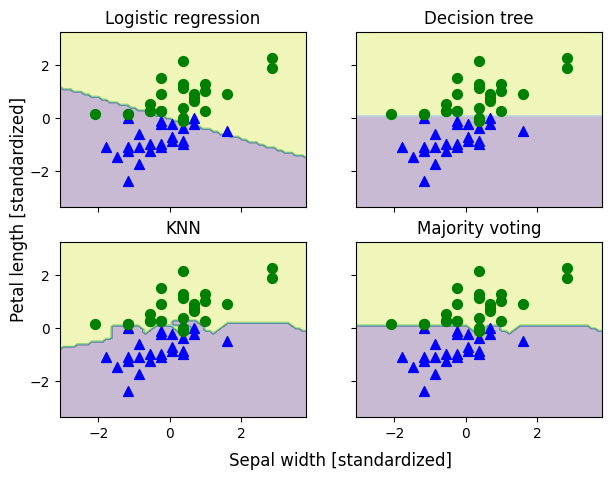

In [8]:
from itertools import product

# Gabungkan semua model (3 model dasar + ensemble)
all_clf = [pipe1, clf2, pipe3, mv_clf]
# Tentukan rentang sumbu untuk area plotting (berdasarkan data training yang sudah distandarisasi)
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
# Buat grid (mesh) titik-titik di area fitur untuk menggambar boundary
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
# Siapkan 4 subplot (2x2) untuk membandingkan tiap model
f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train) # Latih model dengan data training
    # Prediksi semua titik di grid untuk membuat peta keputusan
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Gambar area (region) berdasarkan hasil prediksi kelas
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    # Plot titik data training kelas 0 (biru, segitiga)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    # Plot titik data training kelas 1 (hijau, lingkaran)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    # Judul setiap subplot sesuai nama model
    axarr[idx[0], idx[1]].set_title(tt)
# Tambahkan label sumbu (hanya ditulis sekali di bawah & kiri)
plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)
# Simpan atau tampilkan hasil plot (matikan save sementara)
#plt.savefig('figures/07_05', dpi=300)
plt.show()

## 🔍 Optimasi Hyperparameter pada Majority Voting Classifier

Pada tahap ini dilakukan **tuning hyperparameter** menggunakan `GridSearchCV`  
untuk mencari kombinasi parameter terbaik bagi model **MajorityVoteClassifier**.

### ⚙️ Langkah-Langkah:
1. **`mv_clf.get_params()`**  
   Menampilkan semua parameter yang dapat diatur pada ensemble classifier (termasuk pipeline dan model dasar).  
2. **Mendefinisikan Grid Parameter (`params`)**  
   - `decisiontreeclassifier__max_depth`: mengatur kedalaman pohon keputusan.  
   - `pipeline-1__clf__C`: mengatur regularisasi pada Logistic Regression.  
3. **Menjalankan `GridSearchCV`**  
   - Menggunakan *10-fold cross-validation* dan metrik **ROC AUC**.  
   - Mengevaluasi kombinasi parameter terbaik dengan skor rata-rata dan deviasi standar.  
4. **Menampilkan hasil terbaik**  
   - `best_params_`: kombinasi parameter optimal.  
   - `best_score_`: nilai ROC AUC tertinggi.  
5. **Memperbarui model `mv_clf`**  
   - Mengambil model terbaik (`best_estimator_`) dari hasil GridSearch.  
   - Menyimpan ulang parameter optimal ke dalam `mv_clf` untuk digunakan pada tahap evaluasi berikutnya.

### 🎯 Tujuan:
Meningkatkan performa ensemble dengan menemukan konfigurasi parameter yang paling optimal  
melalui proses pencarian sistematis berbasis cross-validation.


In [9]:
# Melihat semua parameter yang dapat di-tuning dalam MajorityVoteClassifier
mv_clf.get_params() 

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [10]:
from sklearn.model_selection import GridSearchCV

# Grid hyperparameter yang akan diuji
# - max_depth: kedalaman pohon pada Decision Tree
# - C: parameter regularisasi untuk Logistic Regression di pipeline-1
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

# Membuat objek GridSearchCV untuk mencari kombinasi parameter terbaik
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,              # 10-fold cross validation
                    scoring='roc_auc')  # metrik evaluasi menggunakan ROC AUC
# Melatih model dengan semua kombinasi parameter
grid.fit(X_train, y_train)

# Menampilkan hasil skor rata-rata dan deviasi standar dari setiap kombinasi parameter
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [11]:
# Menampilkan kombinasi parameter terbaik dan skor AUC tertingginya
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.98


In [12]:
# Menampilkan classifier-classifier dalam model ensemble terbaik
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [13]:
# Menyimpan model terbaik hasil GridSearch ke variabel mv_clf
mv_clf = grid.best_estimator_

In [14]:
# Memperbarui parameter mv_clf agar sama dengan model terbaik
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=1),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

<br>
<br>

# 🍷 Bagging — Membangun Ensemble Classifier dari Bootstrap Samples  
## 🧩 Penerapan Bagging pada Dataset Wine

**Bagging (Bootstrap Aggregating)** adalah teknik ensemble learning  
yang melatih beberapa model (biasanya pohon keputusan) pada **subset acak dari data pelatihan**  
yang diambil dengan *replacement* (bootstrap sampling).  

Setiap model dilatih secara independen, dan hasil prediksi digabungkan melalui **voting mayoritas**  
(untuk klasifikasi) atau **rata-rata** (untuk regresi).  

Dalam implementasi pada *Wine Dataset*:  
- Model dasar yang digunakan adalah **Decision Tree** dengan kriteria *entropy*.  
- Teknik Bagging dibuat dengan **`BaggingClassifier`** dari Scikit-learn.  
- Ensemble dilatih menggunakan **500 estimator**, masing-masing mempelajari sampel acak berbeda.  
- Hasil evaluasi menunjukkan bahwa Bagging dapat mengurangi *overfitting* dan meningkatkan akurasi pada data uji dibanding pohon tunggal.  

Secara keseluruhan, bagian ini menunjukkan bagaimana **ensembling sederhana** dapat secara signifikan meningkatkan stabilitas dan generalisasi model.


# 🍷 Bagging — Membangun Ensemble Classifier dari Bootstrap Samples  
## 🧩 Penerapan Bagging untuk Klasifikasi pada Dataset Wine

### 📘 Deskripsi Singkat
**Bagging (Bootstrap Aggregating)** adalah teknik *ensemble learning*  
yang bertujuan untuk meningkatkan akurasi dan stabilitas model,  
terutama model yang cenderung *high variance* seperti **Decision Tree**.  

Dalam metode ini:
- Data pelatihan di-*bootstrap* menjadi beberapa subset acak (dengan pengembalian).  
- Setiap subset digunakan untuk melatih satu model dasar (*base estimator*).  
- Hasil prediksi dari semua model kemudian digabung dengan **voting mayoritas** (klasifikasi)  
  atau **rata-rata** (regresi).  

---

### 🧮 Langkah-Langkah Implementasi

1. **Memuat Dataset Wine** dari UCI Machine Learning Repository.  
   - Menggunakan hanya dua fitur: `Alcohol` dan `OD280/OD315 of diluted wines`.  
   - Menghapus satu kelas agar menjadi masalah klasifikasi biner.  

2. **Melakukan Encoding Label**
   - Menggunakan `LabelEncoder` untuk mengubah label kelas (`2` → `0`, `3` → `1`).

3. **Membagi Dataset**
   - Data dibagi menjadi **80% data latih** dan **20% data uji** menggunakan `train_test_split`.  
   - Parameter `stratify=y` memastikan proporsi kelas tetap seimbang.

4. **Membangun Model**
   - Model dasar: `DecisionTreeClassifier` dengan kriteria `entropy`.  
   - Model ensemble: `BaggingClassifier` dengan 500 estimator, bootstrap aktif, dan semua fitur digunakan.  

5. **Evaluasi Kinerja**
   - Menghitung akurasi model *Decision Tree tunggal* dan *Bagging ensemble*  
     pada data latih dan data uji menggunakan `accuracy_score`.  
   - Biasanya, Bagging menghasilkan akurasi uji yang lebih tinggi dan *overfitting* yang lebih rendah.

6. **Visualisasi Decision Boundary**
   - Menampilkan pembagian area prediksi (*decision regions*) antara kelas 0 dan 1  
     untuk model **Decision Tree** dan **Bagging**.  
   - Plot ini menunjukkan bahwa **Bagging menghasilkan batas keputusan yang lebih halus dan stabil**,  
     karena efek rata-rata dari banyak model.

---

### 🎯 Kesimpulan
- **Decision Tree tunggal** mudah *overfit* terhadap data latih (akurasi latih tinggi, uji lebih rendah).  
- **Bagging ensemble** mampu memperbaiki hal tersebut dengan mengurangi variansi model.  
- Hasil visualisasi memperlihatkan bahwa Bagging menciptakan **pemisahan kelas yang lebih konsisten**  
  dan **lebih generalisasi terhadap data baru**.

Dengan demikian, Bagging merupakan langkah awal yang efektif sebelum mencoba metode boosting seperti **AdaBoost** atau **XGBoost**.


In [16]:
import pandas as pd

#  Mengimpor dataset Wine dari UCI Machine Learning Repository
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'           # Silakan diisi bagian ini dengan kode yang tepat (2)
                      'machine-learning-databases/wine/wine.data',
                      header=None)

#  Menambahkan nama kolom agar lebih mudah dibaca
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

#  Menghapus kelas label 1 → menyisakan dua kelas (2 dan 3) untuk klasifikasi biner
df_wine = df_wine[df_wine['Class label'] != 1]

#  Memisahkan target (y) dan fitur (X)
y = df_wine['Class label'].values  # target (kelas anggur)
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values  # dua fitur utama untuk analisis


In [17]:
from sklearn.preprocessing import LabelEncoder

#  Membuat objek LabelEncoder untuk mengubah label kategorikal menjadi numerik
le = LabelEncoder()                                                 # Silakan diisi bagian ini dengan kode yang tepat (2)

#  Melatih encoder dan mengubah label kelas menjadi angka
# Secara otomatis: Class 2 → 0, Class 3 → 1
y = le.fit_transform(y)

#  Mengecek hasil encoding untuk memastikan konversi berhasil
print("Label unik setelah encoding:", np.unique(y))


Label unik setelah encoding: [0 1]


In [18]:
from sklearn.model_selection import train_test_split

#  Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(                      # Silakan diisi bagian ini dengan kode yang tepat (1)
    X, y,
    test_size=0.2,                                       # Silakan diisi bagian ini dengan kode yang tepat (1)
    random_state=1,                                         # Silakan diisi bagian ini dengan kode yang tepat (1)
    stratify=y                                       # Silakan diisi bagian ini dengan kode yang tepat (1)
)

#  Menampilkan ukuran data hasil pembagian
print("Ukuran X_train:", X_train.shape)              # Silakan diisi bagian ini dengan kode yang tepat (1)
print("Ukuran X_test :", X_test.shape)               # Silakan diisi bagian ini dengan kode yang tepat (1)

#  Mengecek distribusi label agar tidak ada ketimpangan antara train dan test
print("\nDistribusi label:")    
print("Total :", np.bincount(y))                        # Silakan diisi bagian ini dengan kode yang tepat (1)
print("Train :", np.bincount(y_train))                  # Silakan diisi bagian ini dengan kode yang tepat (1)
print("Test  :", np.bincount(y_test))                   # Silakan diisi bagian ini dengan kode yang tepat (1)


Ukuran X_train: (95, 2)
Ukuran X_test : (24, 2)

Distribusi label:
Total : [71 48]
Train : [57 38]
Test  : [14 10]


Sebelum membuat model ensemble Bagging, perhatikan parameter penting yang harus diisi:

| Parameter | Tipe / Contoh Nilai | Rentang Umum | Fungsi | Efek Nilai |
|------------|--------------------|---------------|---------|-------------|
| **criterion** | `'gini'` atau `'entropy'` | dua pilihan tetap | Menentukan cara mengukur impurity saat split | `'gini'` → lebih cepat, `'entropy'` → lebih informatif tapi sedikit lebih lambat |
| **max_depth** | `None`, `3`, `5`, ... | `None` atau bilangan positif | Membatasi kedalaman maksimum pohon | `None` → pohon bisa overfit; nilai kecil → model lebih sederhana (*underfit*) |
| **estimator** | `DecisionTreeClassifier()` | model dasar apa pun | Model dasar yang digunakan di dalam ensemble | Gunakan model sederhana agar variasi antar estimator tinggi |
| **n_estimators** | `10`, `100`, `500` | ≥1 | Jumlah model individu dalam ensemble | Semakin besar → akurasi naik, tapi waktu pelatihan lebih lama |
| **max_samples** | `0.5`–`1.0` | 0 < x ≤ 1 | Persentase data bootstrap yang digunakan per estimator | Lebih kecil → lebih bervariasi, tapi tiap model punya data lebih sedikit |
| **max_features** | `0.5`–`1.0` | 0 < x ≤ 1 | Persentase fitur yang digunakan | Lebih kecil → menambah variasi, tapi bisa kehilangan informasi |
| **bootstrap** | `True` / `False` | Boolean | Mengambil sampel data dengan pengembalian (re-sampling) | `True` = metode Bagging klasik |
| **bootstrap_features** | `True` / `False` | Boolean | Apakah fitur juga di-bootstrap | Biasanya `False` untuk menjaga kestabilan model |
| **random_state** | `int` (misal `1`) | angka bulat | Mengontrol hasil acak agar bisa direproduksi | Semakin sama nilai → hasil tetap sama |
| **n_jobs** | `1` atau `-1` | bilangan bulat | Menentukan jumlah core CPU untuk paralelisasi | `-1` = gunakan semua core untuk percepatan |

---

In [65]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Membuat model dasar berupa pohon keputusan
tree = DecisionTreeClassifier(
    criterion='entropy',       # Silakan diisi bagian ini dengan kode yang tepat (2)
    max_depth=1,         # Silakan diisi bagian ini dengan kode yang tepat (2)
    random_state= 1      # Silakan diisi bagian ini dengan kode yang tepat (1)
)

#  Membuat model Bagging (Bootstrap Aggregating)
bag = BaggingClassifier(
    estimator=tree,             # Silakan diisi bagian ini dengan kode yang tepat (2)
    n_estimators=500,          # Silakan diisi bagian ini dengan kode yang tepat (1)
    max_samples=1.0,           # Silakan diisi bagian ini dengan kode yang tepat (1)
    max_features=1.0,          # Silakan diisi bagian ini dengan kode yang tepat (1)
    bootstrap=True,             # Silakan diisi bagian ini dengan kode yang tepat (2)
    bootstrap_features=False,    # Silakan diisi bagian ini dengan kode yang tepat (2)
    n_jobs=-1,                # Silakan diisi bagian ini dengan kode yang tepat (1)
    random_state=1           # Silakan diisi bagian ini dengan kode yang tepat (1)
)


In [66]:
from sklearn.metrics import accuracy_score

#  Latih model Decision Tree tunggal
tree = tree.fit(X_train, y_train)

#  Prediksi hasil untuk data latih dan data uji
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

#  Hitung akurasi model Decision Tree
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

#  Latih model Bagging yang berisi banyak Decision Tree
bag = bag.fit(X_train, y_train)

#  Prediksi hasil untuk data latih dan uji menggunakan model Bagging
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

#  Hitung akurasi model Bagging
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')


Decision tree train/test accuracies 0.916/0.875
Bagging train/test accuracies 0.916/0.875


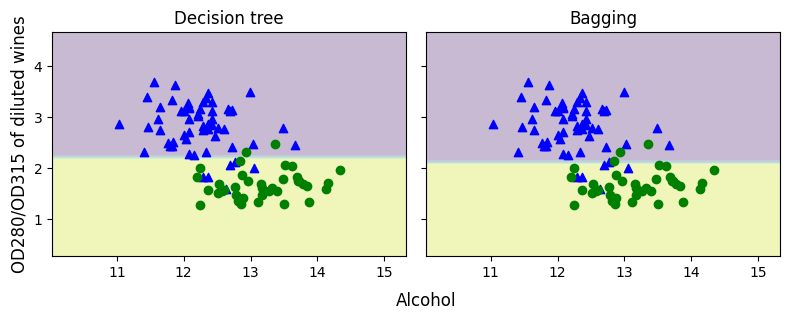

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# 🔢 Tentukan rentang sumbu x dan y berdasarkan data latih
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

#  Membuat grid koordinat untuk memetakan area prediksi
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

#  Membuat dua subplot berdampingan untuk perbandingan model
f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))

#  Latih dan plot area keputusan untuk masing-masing model (Decision Tree & Bagging)
for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    #  Prediksi kelas untuk setiap titik pada grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #  Plot area keputusan model
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)

    # (biru) Titik data kelas 0 dan (hijau) kelas 1
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    #  Judul tiap subplot
    axarr[idx].set_title(tt)

#  Label sumbu Y
axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

#  Tata letak dan label sumbu X
plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#  Tampilkan hasil visualisasi
plt.show()


# ⚡ Boosting — Meningkatkan Performa Model dengan AdaBoost  
## 🧠 Penerapan AdaBoost pada Dataset Wine

**AdaBoost (Adaptive Boosting)** adalah algoritma *ensemble learning* yang meningkatkan performa model sederhana (biasanya *Decision Tree stump* — pohon dengan kedalaman 1).  
Berbeda dengan Bagging yang melatih model secara independen, AdaBoost melatih model **secara berurutan**,  
di mana setiap model baru berfokus pada data yang **sulit diklasifikasikan oleh model sebelumnya**.

### 🔹 Proses yang dilakukan:
1. Model dasar: **Decision Tree** dengan kedalaman maksimum 1.  
2. Dibangun **500 model berturut-turut** (`n_estimators=500`) dengan tingkat pembelajaran (`learning_rate=0.1`).  
3. Setiap model diberi bobot berdasarkan tingkat kesalahannya — data yang salah diklasifikasi akan lebih ditekankan pada iterasi berikutnya.  
4. Hasil akhir berupa **gabungan model lemah (weak learners)** menjadi satu model kuat (strong classifier).  

### 📊 Hasil dan Visualisasi
- Kode pertama menghitung akurasi pada data latih dan uji untuk:
  - **Decision Tree tunggal** (baseline)
  - **AdaBoost Ensemble**
- Kode kedua memvisualisasikan **batas keputusan (decision boundary)** kedua model.  
  - *Decision Tree*: batas kasar dan sensitif terhadap data.  
  - *AdaBoost*: batas lebih halus dan adaptif terhadap pola data sulit.  

Secara umum, hasil menunjukkan bahwa **AdaBoost meningkatkan akurasi model** dan menghasilkan klasifikasi yang lebih stabil dibanding pohon tunggal.


## ⚙️ Parameter pada Model AdaBoostClassifier

Sebelum membuat model **AdaBoost (Adaptive Boosting)**, pahami parameter utama yang mengatur bagaimana model memperkuat *weak learners* (model lemah seperti decision stump).

| Parameter | Tipe / Contoh Nilai | Rentang Umum | Fungsi | Efek Nilai |
|------------|--------------------|---------------|---------|-------------|
| **estimator** | `DecisionTreeClassifier()` | model dasar apa pun | Model lemah yang akan diperkuat oleh boosting | Biasanya digunakan pohon keputusan dangkal (depth=1) agar fokus pada kombinasi banyak model sederhana |
| **criterion** *(pada tree)* | `'gini'` atau `'entropy'` | dua pilihan tetap | Mengukur impurity untuk split pada pohon | `'entropy'` → lebih informatif, `'gini'` → lebih cepat |
| **max_depth** *(pada tree)* | `1`, `2`, `3`, ... | bilangan positif | Mengatur kedalaman pohon dasar | `1` = *decision stump* (sangat sederhana); nilai besar → risiko overfitting |
| **n_estimators** | `50`, `100`, `500`, ... | ≥1 | Jumlah model lemah yang digabung dalam boosting | Lebih banyak model → akurasi bisa naik, tapi risiko overfitting & waktu latih meningkat |
| **learning_rate** | `0.01` – `1.0` | 0 < x ≤ 1 | Mengatur bobot kontribusi tiap model lemah | Nilai kecil → pelatihan lebih lambat tapi stabil; nilai besar → lebih cepat tapi bisa tidak stabil |
| **random_state** | `int` (misal `1`) | angka bulat | Mengatur hasil acak agar reproducible | Menjamin hasil tetap sama setiap dijalankan |

---

In [77]:
from sklearn.ensemble import AdaBoostClassifier

#  Model dasar: Decision Tree sederhana 
tree = DecisionTreeClassifier(
    criterion='gini',        # Silakan diisi bagian ini dengan kode yang tepat (2)
    max_depth=1,          # Silakan diisi bagian ini dengan kode yang tepat (2)
    random_state=1        # Silakan diisi bagian ini dengan kode yang tepat (1)
)

#  Membuat model AdaBoost (Adaptive Boosting)
ada = AdaBoostClassifier(
    estimator=tree,        
    n_estimators=500,     # Silakan diisi bagian ini dengan kode yang tepat (2)
    learning_rate=0.1,    # Silakan diisi bagian ini dengan kode yang tepat (3)
    random_state=1      # Silakan diisi bagian ini dengan kode yang tepat (1)
)


In [78]:
#  Latih model Decision Tree tunggal
tree = tree.fit(X_train, y_train)

#  Prediksi hasil untuk data latih dan data uji
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

#  Hitung akurasi model Decision Tree pada data latih dan uji
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

#  Latih model AdaBoost (ensemble dari banyak Decision Tree)
ada = ada.fit(X_train, y_train)

#  Prediksi hasil untuk data latih dan data uji menggunakan model AdaBoost
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

#  Hitung akurasi model AdaBoost
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')


Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.958/0.917


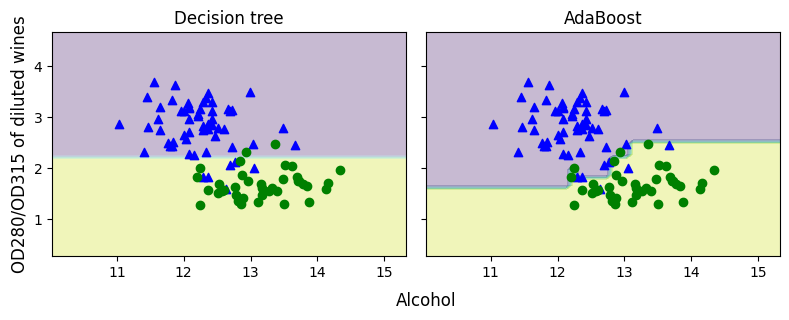

In [79]:
#  Tentukan rentang nilai fitur untuk membuat grid plotting (sumbu X & Y)
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

#  Membuat grid koordinat untuk memvisualisasikan area keputusan model
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

#  Membuat dua subplot sejajar: satu untuk Decision Tree, satu untuk AdaBoost
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))

#  Latih dan plot area keputusan untuk masing-masing model
for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    # 🔮 Prediksi kelas untuk seluruh titik dalam grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #  Gambar area keputusan dengan warna berbeda per kelas
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)

    #  Plot titik data kelas 0 (segitiga biru)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    #  Plot titik data kelas 1 (lingkaran hijau)
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    #  Judul subplot: model yang sedang divisualisasikan
    axarr[idx].set_title(tt)

#  Label sumbu Y
axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

#  Tata letak dan label sumbu X
plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#  Tampilkan visualisasi perbandingan Decision Tree vs AdaBoost
plt.show()


## 🚀 **Menggunakan XGBoost untuk Klasifikasi Berbasis Gradient Boosting**

<p>
Pada bagian ini, kita akan menerapkan <b>XGBoost (Extreme Gradient Boosting)</b> — salah satu algoritma ensemble paling kuat yang termasuk dalam keluarga <i>gradient boosting</i>.  
Model ini bekerja dengan menggabungkan banyak pohon keputusan sederhana secara bertahap,  
di mana setiap pohon baru berusaha memperbaiki kesalahan dari pohon-pohon sebelumnya.
</p>

---

### ⚙️ **Parameter Penting pada XGBoost**

| Parameter | Tipe / Contoh Nilai | Rentang Umum | Fungsi | Efek Nilai |
|------------|--------------------|---------------|---------|-------------|
| **n_estimators** | `100`, `500`, `1000` | ≥ 1 | Menentukan jumlah pohon (model lemah) yang dibangun secara bertahap | Nilai besar → model lebih kuat dan stabil, tapi waktu latih lebih lama dan berisiko overfitting |
| **learning_rate** | `0.01`, `0.1`, `0.3` | 0 < x ≤ 1 | Mengatur seberapa besar kontribusi setiap pohon baru terhadap model akhir | Nilai kecil → pembelajaran lebih lambat tapi stabil; nilai besar → cepat konvergen tapi bisa tidak stabil |
| **max_depth** | `3`, `4`, `6` | bilangan positif | Mengontrol kedalaman maksimum tiap pohon keputusan | Nilai kecil → model lebih sederhana (*underfit*); nilai besar → lebih kompleks (*overfit*) |
| **subsample** | `0.5` – `1.0` | 0 < x ≤ 1 | Persentase data sampel yang digunakan untuk melatih setiap pohon | Nilai kecil → menambah variasi & mengurangi overfitting; terlalu kecil → bisa *underfit* |
| **colsample_bytree** | `0.5` – `1.0` | 0 < x ≤ 1 | Persentase fitur yang digunakan oleh setiap pohon | Nilai kecil → menambah keragaman model; nilai besar → model lebih stabil tapi bisa overfit |
| **gamma** | `0`, `0.1`, `1` | ≥ 0 | Menentukan minimum penurunan loss agar split dilakukan | Nilai besar → membatasi jumlah split → model lebih konservatif |
| **min_child_weight** | `1`, `5`, `10` | ≥ 0 | Minimum bobot total data pada satu node agar bisa di-split | Nilai besar → mengurangi overfitting (lebih konservatif) |
| **random_state** | `int` (misal `1`) | angka bulat | Mengontrol hasil acak untuk reproducibility | Menjamin hasil tetap sama di setiap eksekusi |
| **use_label_encoder** | `True` / `False` | Boolean | Pengaturan kompatibilitas dengan versi baru XGBoost | Biasanya diset `False` untuk menghindari peringatan (warning) versi baru |

---

### 🧭 **Langkah-langkah Eksperimen**

1. **Inisialisasi model XGBoost** dengan parameter yang sesuai (jumlah estimator, kedalaman pohon, dan laju pembelajaran).  
2. **Latih model (`fit`)** menggunakan data training (`X_train`, `y_train`).  
3. **Lakukan prediksi (`predict`)** pada data latih dan uji.  
4. **Evaluasi hasil** menggunakan metrik akurasi (`accuracy_score`) untuk melihat performa model dalam belajar dan mengeneralisasi data baru.

---

### 🎯 **Tujuan Akhir**
Menilai kemampuan **XGBoost** dalam meningkatkan akurasi dan stabilitas prediksi dibandingkan metode ensemble lain  
seperti **Bagging** dan **AdaBoost**, serta memahami bagaimana parameter utamanya memengaruhi performa model.


In [55]:
import xgboost as xgb

xgb.__version__

'2.1.3'

In [60]:
#  Inisialisasi model XGBoost Classifier
 # Silakan diisi bagian ini dengan kode yang tepat ()
model = xgb.XGBClassifier(
    n_estimators=100,          # Silakan diisi bagian ini dengan kode yang tepat (3)
    learning_rate=0.01,         # Silakan diisi bagian ini dengan kode yang tepat (3)
    max_depth=3,             # Silakan diisi bagian ini dengan kode yang tepat (3)
    random_state=1,          # Silakan diisi bagian ini dengan kode yang tepat (1)
    use_label_encoder=False      # Silakan diisi bagian ini dengan kode yang tepat (3)
)

#  Latih model XGBoost dengan data training
gbm = model.fit(X_train, y_train)

#  Prediksi kelas untuk data training dan testing
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

#  Hitung akurasi model pada data training dan testing
gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)

#  Tampilkan hasil akurasi model XGBoost
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')


/opt/tljh/user/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:58:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGboost train/test accuracies 0.937/0.917


In [61]:
import pickle

# Simpan model XGBoost yang sudah dilatih ke file .pkl (format biner)
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
# Konfirmasi bahwa model berhasil disimpan
print(" Model XGBoost berhasil disimpan ke xgboost_model.pkl")


 Model XGBoost berhasil disimpan ke xgboost_model.pkl


<br>
<br>